# CRDCDH Semantic Similarity Analysis with Word2Vec by BlazingText



Word2Vec is a popular algorithm used for generating dense vector representations of words in large corpora using unsupervised learning. The resulting vectors have been shown to capture semantic relationships between the corresponding words and are used extensively for many downstream natural language processing (NLP) tasks like sentiment analysis, named entity recognition and machine translation.  

SageMaker BlazingText which provides efficient implementations of Word2Vec on

- single CPU instance
- single instance with multiple GPUs - P2 or P3 instances
- multiple CPU instances (Distributed training)

In this notebook, BlazingText is used for distributed training of word2vec using multiple CPU instances.

## Setup

Let's start by specifying:
- The S3 buckets and prefixes that you want to use for saving model data and where training data is located. These should be within the same region as the Notebook Instance, training, and hosting. If you don't specify a bucket, SageMaker SDK will create a default bucket following a pre-defined naming convention in the same region. 
- The IAM role ARN used to give SageMaker access to your data. It can be fetched using the **get_execution_role** method from sagemaker python SDK.

In [ ]:
import sagemaker
import boto3
import json
from common.sagemaker_utils import get_sagemaker_session, delete_endpoint, get_sagemaker_execute_role, normalize_word_vector, create_local_output_dirs
import common.sagemaker_config as config

sess = get_sagemaker_session()
role = get_sagemaker_execute_role(sess)
print(role)  # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf
region_name = boto3.Session().region_name

output_bucket = sess.default_bucket()  # Replace with your own bucket name if needed
# print(output_bucket)
output_prefix = "crdcdh-ml/sagemaker/blazingtext-text8"  # Replace with the prefix under which you want to store the data if needed
s3_train_data = f"s3://{output_bucket}/{output_prefix}/train"
s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"
create_local_output_dirs(["../output", "../output/model", "../data", "../images"])

## Training Setup
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

In [ ]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print(f"Using SageMaker BlazingText container: {container} ({region_name})")

## Training the BlazingText model for generating word vectors

Similar to the original implementation of [Word2Vec](https://arxiv.org/pdf/1301.3781.pdf), SageMaker BlazingText provides an efficient implementation of the continuous bag-of-words (CBOW) and skip-gram architectures using Negative Sampling, on CPUs and additionally on GPU[s]. The GPU implementation uses highly optimized CUDA kernels. To learn more, please refer to [*BlazingText: Scaling and Accelerating Word2Vec using Multiple GPUs*](https://dl.acm.org/citation.cfm?doid=3146347.3146354). BlazingText also supports learning of subword embeddings with CBOW and skip-gram modes. This enables BlazingText to generate vectors for out-of-vocabulary (OOV) words, as demonstrated in this [notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/blazingtext_word2vec_subwords_text8/blazingtext_word2vec_subwords_text8.ipynb).




Besides skip-gram and CBOW, SageMaker BlazingText also supports the "Batch Skipgram" mode, which uses efficient mini-batching and matrix-matrix operations ([BLAS Level 3 routines](https://software.intel.com/en-us/mkl-developer-reference-fortran-blas-level-3-routines)). This mode enables distributed word2vec training across multiple CPU nodes, allowing almost linear scale up of word2vec computation to process hundreds of millions of words per second. Please refer to [*Parallelizing Word2Vec in Shared and Distributed Memory*](https://arxiv.org/pdf/1604.04661.pdf) to learn more.

BlazingText also supports a *supervised* mode for text classification. It extends the FastText text classifier to leverage GPU acceleration using custom CUDA kernels. The model can be trained on more than a billion words in a couple of minutes using a multi-core CPU or a GPU, while achieving performance on par with the state-of-the-art deep learning text classification algorithms. For more information, please refer to [algorithm documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html) or [the text classification notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/blazingtext_text_classification_dbpedia/blazingtext_text_classification_dbpedia.ipynb).

In [ ]:
bt_model = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=2,
    instance_type="ml.c4.2xlarge",
    train_volume_size=5,
    train_max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    sagemaker_session=sess,
)

Please refer to [algorithm documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html) for the complete list of hyperparameters.

In [ ]:
bt_model.set_hyperparameters(
    mode="batch_skipgram",
    epochs=5,
    min_count=5,
    sampling_threshold=0.0001,
    learning_rate=0.05,
    window_size=5,
    vector_dim=100,
    negative_samples=5,
    batch_size=11,  #  = (2*window_size + 1) (Preferred. Used only if mode is batch_skipgram)
    evaluation=True,  # Perform similarity evaluation on WS-353 dataset at the end of training
    subwords=False, # Subword embedding learning is not supported by batch_skipgram
)  

Now that the hyper-parameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.

In [ ]:
train_data = sagemaker.session.s3_input(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data}

We have our `Estimator` object, we have set the hyper-parameters for this object and we have our data channels linked with the algorithm. The only  remaining thing to do is to train the algorithm. The following command will train the algorithm. Training the algorithm involves a few steps. Firstly, the instance that we requested while creating the `Estimator` classes is provisioned and is setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take some time, depending on the size of the data. Therefore it might be a few minutes before we start getting training logs for our training jobs. The data logs will also print out `Spearman's Rho` on some pre-selected validation datasets after the training job has executed. This metric is a proxy for the quality of the algorithm. 

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [ ]:
bt_model.fit(inputs=data_channels, logs=True)

## Hosting / Inference
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same type of instance that we used to train. Because instance endpoints will be up and running for long, it's advisable to choose a cheaper instance for inference.

In [ ]:
endpoint_name = f"{config.SOLUTION_PREFIX}-semantic-analysis"
# delete endpoint and endpoint configuration if existing before deploy
delete_endpoint(endpoint_name)
bt_endpoint = bt_model.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1,
    instance_type=config.HOSTING_INSTANCE_TYPE
)

### Getting vector representations for words

#### Use JSON format for inference
The payload should contain a list of words with the key as "**instances**". BlazingText supports content-type `application/json`.

In [ ]:
words = ["awesome", "blazing"]
payload = {"instances": words}
response = bt_endpoint.predict(
    json.dumps(payload),
    initial_args={"ContentType": "application/json", "Accept": "application/json"},
)
vecs = json.loads(response)
print(vecs)

As expected, we get an n-dimensional vector (where n is vector_dim as specified in hyperparameters) for each of the words. If the word is not there in the training dataset, the model will return a vector of zeros.

### Evaluation

Let us now download the word vectors learned by our model and visualize them using a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) plot.

In [ ]:
s3 = boto3.resource("s3")

key = bt_model.model_data[bt_model.model_data.find("/", 5) + 1 :]
s3.Bucket(output_bucket).download_file(key, "../output/model.tar.gz")

Uncompress `model.tar.gz` to get `vectors.txt`

In [ ]:
!tar -xvzf ../output/model.tar.gz -C ../output/model

If you set "evaluation" as "true" in the hyperparameters, then "eval.json" will be there in the model artifacts.

The quality of trained model is evaluated on word similarity task. We use [WS-353](http://alfonseca.org/eng/research/wordsim353.html), which is one of the most popular test datasets used for this purpose. It contains word pairs together with human-assigned similarity judgments.

The word representations are evaluated by ranking the pairs according to their cosine similarities, and measuring the Spearmans rank correlation coefficient with the human judgments.

Let's look at the evaluation scores which are there in eval.json. For embeddings trained on the text8 dataset, scores above 0.65 are pretty good.

In [ ]:
!cat ../output/model/eval.json

Now, let us do a 2D visualization of the word vectors

In [ ]:
num_points = 400 #Read the 400 most frequent word vectors by default. The vectors in the file are in descending order of frequency.
word_vecs, index_to_word = normalize_word_vector("../output/model/vectors.txt", num_points)
# print(word_vecs[:2])
# print(index_to_word[:2])

In [ ]:
from common.visualize_word_vector import plot_word_vector_tsne

perplexity= 40 if len(index_to_word) > 0 else len(index_to_word) -1
plot_word_vector_tsne(word_vecs[:num_points], index_to_word[:num_points], perplexity, "../images/model_evel_tsne.png")

Running the code above might generate a plot like the one below. t-SNE and Word2Vec are stochastic, so although when you run the code the plot won’t look exactly like this, you can still see clusters of similar words such as below where 'british', 'american', 'french', 'english' are near the bottom-left, and 'military', 'army' and 'forces' are all together near the bottom.

![tsne plot of embeddings](../images/tsne.png)
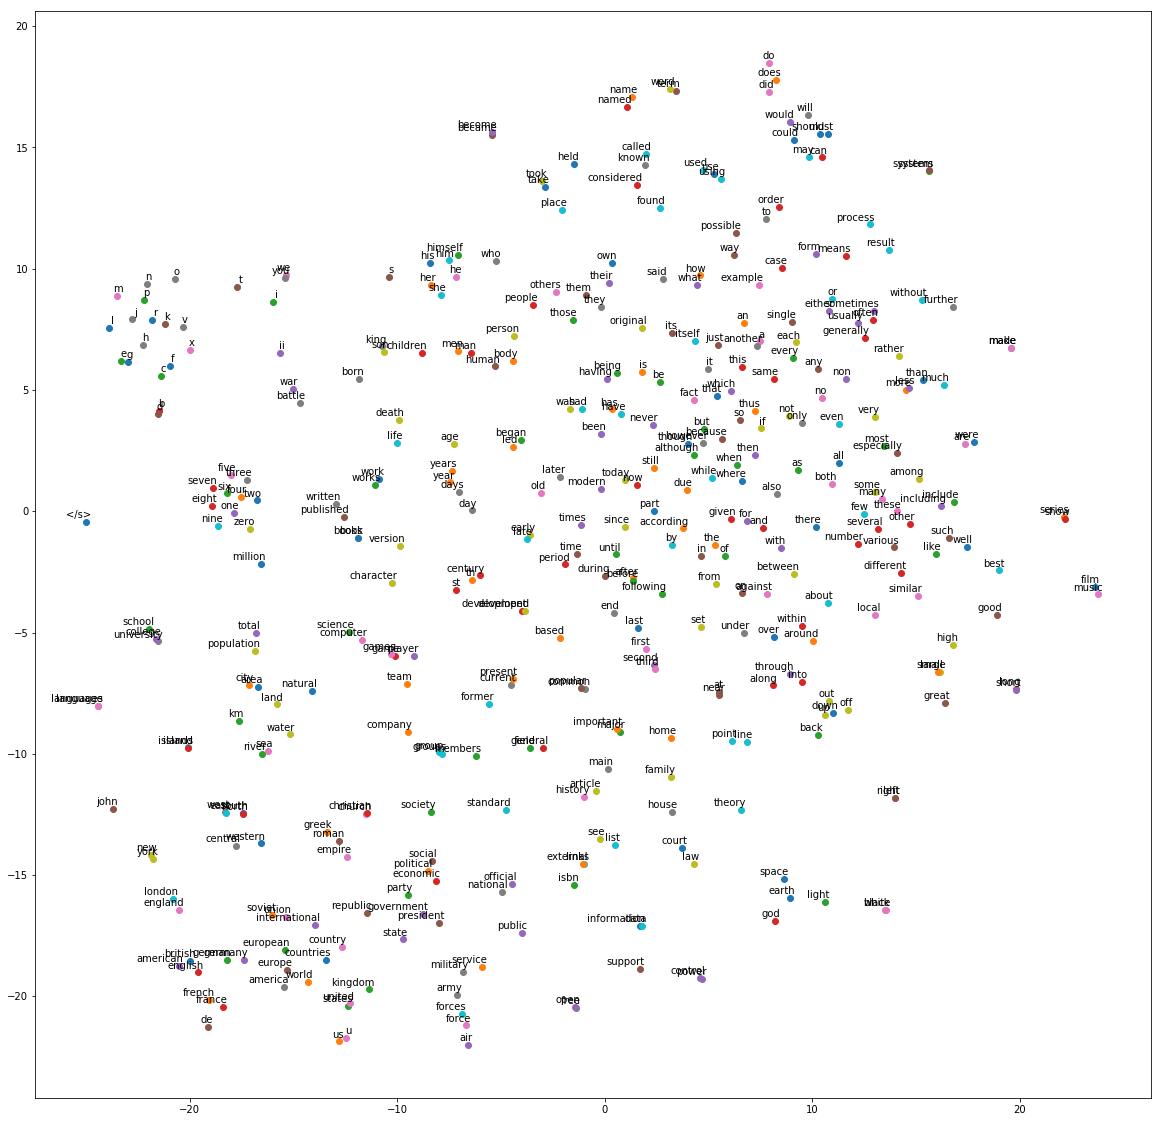

### Stop / Close the Endpoint (Optional)
Finally, we should delete the endpoint before we close the notebook.

In [ ]:
# # Delete the SageMaker endpoint and the attached resources
delete_endpoint(endpoint_name)